# Epistemic Nearest Neighbors (ENN)

ENN is a non-parametric surrogate with $O(N)$ computation-time scaling, where $N$ is the number of observations in the data set. ENN can be used in Bayesian optimization as a scalable alternative to a GP (which scales as $O(N^2)$.)

**Sweet, D., & Jadhav, S. A. (2025).** Taking the GP Out of the Loop. *arXiv preprint arXiv:2506.12818*.  
   https://arxiv.org/abs/2506.12818

   ---

In [1]:
import numpy as np

from enn import EpistemicNearestNeighbors, enn_fit
from enn.enn.enn_params import PosteriorFlags


def make_enn_demo_data(num_samples: int, k: int, noise: float, m: int = 1):
    x = np.sort(np.random.rand(num_samples + 4))
    x[-3] = x[-4]
    x[-2] = x[-4]
    x[-1] = x[-4]
    x[1] = x[0] + 0.03
    eps = np.random.randn(num_samples + 4)
    y = np.sin(2 * m * np.pi * x) + noise * eps
    yvar = (noise**2) * np.ones_like(y)
    train_x = x[:, None]
    train_y = y[:, None]
    train_yvar = yvar[:, None]
    model = EpistemicNearestNeighbors(
        train_x,
        train_y,
        train_yvar,
    )
    rng = np.random.default_rng(0)
    params = enn_fit(
        model,
        k=k,
        num_fit_candidates=100,
        num_fit_samples=min(10, num_samples),
        rng=rng,
    )
    return x, y, model, params


def plot_enn_posterior(ax, x, y, model, params, num_samples: int, noise: float) -> None:
    x_hat = np.linspace(0.0, 1.0, 30)
    x_hat_2d = x_hat[:, None]
    posterior = model.posterior(x_hat_2d, params=params, flags=PosteriorFlags())
    mu = posterior.mu[:, 0]
    se = posterior.se[:, 0]
    marker_size = 3 if num_samples >= 100 else 15
    ax.scatter(x, y, s=marker_size, color="black", alpha=0.5)
    ax.plot(x_hat, mu, linestyle="--", color="tab:blue", alpha=0.7)
    ax.fill_between(x_hat, mu - 2 * se, mu + 2 * se, color="tab:blue", alpha=0.2)
    ax.set_ylim(-5, 5)
    ax.set_title(f"n={num_samples}, noise={noise}")


def plot_enn_function_samples(
    ax, x, y, model, params, num_samples: int, noise: float, num_functions: int = 10
) -> None:
    x_hat = np.linspace(0.0, 1.0, 100)
    x_hat_2d = x_hat[:, None]
    posterior = model.posterior(x_hat_2d, params=params, flags=PosteriorFlags())
    mu = posterior.mu[:, 0]
    se = posterior.se[:, 0]
    ax.fill_between(x_hat, mu - 2 * se, mu + 2 * se, color="tab:blue", alpha=0.2)
    for i in range(num_functions):
        f_sample = model.posterior_function_draw(
            x_hat_2d, params, function_seeds=[i], flags=PosteriorFlags()
        )[0]
        ax.plot(
            x_hat,
            f_sample[:, 0],
            color="black",
            alpha=0.5,
            linewidth=0.8,
            linestyle="--",
        )
    marker_size = 3 if num_samples >= 100 else 15
    ax.scatter(x, y, s=marker_size, color="black", alpha=0.5)
    ax.set_ylim(-5, 5)
    ax.set_title(f"n={num_samples}, noise={noise} (samples)")

## Function Estimation & Function Draws

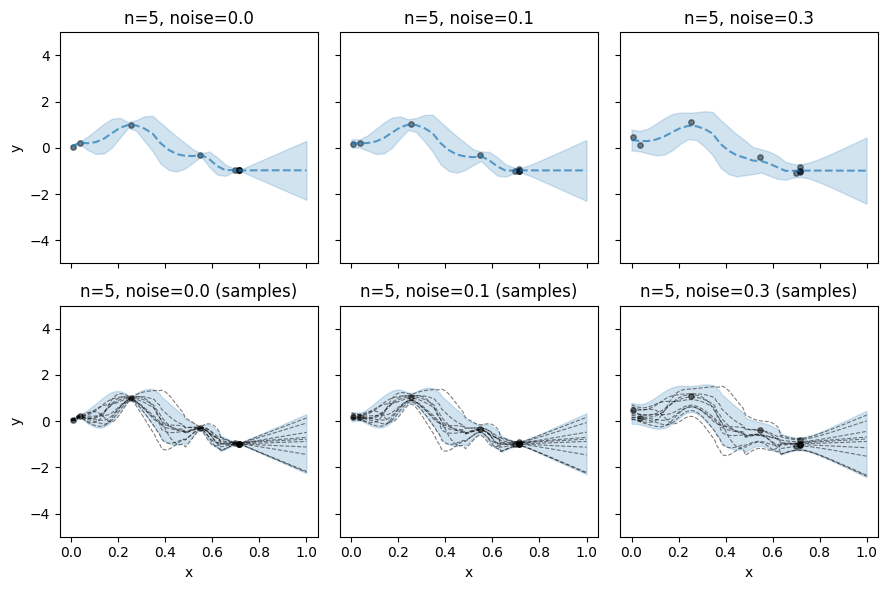

In [2]:
import matplotlib.pyplot as plt

# Row 1: Posterior mean + uncertainty band
# Row 2: 10 function samples from the same model

k = 5
num_samples = 5
noise_list = [0.0, 0.1, 0.3]

fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)

# Build models once per noise level, reuse for both rows
models_and_data = []
for noise in noise_list:
    np.random.seed(4)
    x, y, model, params = make_enn_demo_data(num_samples=num_samples, k=k, noise=noise)
    models_and_data.append((x, y, model, params, noise))

# Row 1: posterior mean + uncertainty
for col_idx, (x, y, model, params, noise) in enumerate(models_and_data):
    ax = axes[0, col_idx]
    plot_enn_posterior(ax, x, y, model, params, num_samples=num_samples, noise=noise)

# Row 2: function samples
for col_idx, (x, y, model, params, noise) in enumerate(models_and_data):
    ax = axes[1, col_idx]
    plot_enn_function_samples(
        ax, x, y, model, params, num_samples=num_samples, noise=noise
    )

for ax in axes[-1, :]:
    ax.set_xlabel("x")
for ax in axes[:, 0]:
    ax.set_ylabel("y")
fig.tight_layout()

## Large Data Set

ENN fits and queries are very fast. This data set uses $N=10^6$ observations.

Time taken: 0.28 seconds


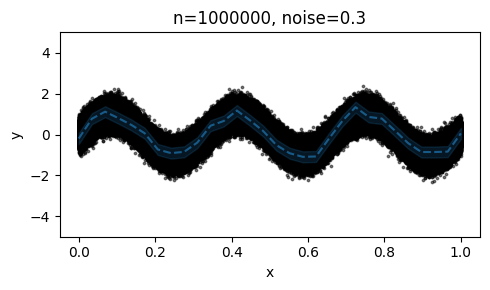

In [3]:
import time
import matplotlib.pyplot as plt

np.random.seed(1)
fig, ax = plt.subplots(figsize=(5, 3))
t_0 = time.time()
x, y, model, params = make_enn_demo_data(num_samples=1_000_000, k=5, noise=0.3, m=3)
plot_enn_posterior(ax, x, y, model, params, num_samples=1_000_000, noise=0.3)
t_1 = time.time()
print(f"Time taken: {t_1 - t_0:.2f} seconds")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.tight_layout()

## Aggregation: Function of Function Draws

When computing a function, $g(\{f(x_i)\})$, over estimates of $f(x_i)$ from multiple $x_i$, it's important to account for the
correlations between the  $g(\{f(x_i)\})$ when calculating the uncertainty in $g(\{f(x_i)\})$. One way to do this is by generating multiple function (joint) draws at $x_i$ and using them to make a Monte Carlo estimate of the distribution of $g(\{f(x_i)\})$.

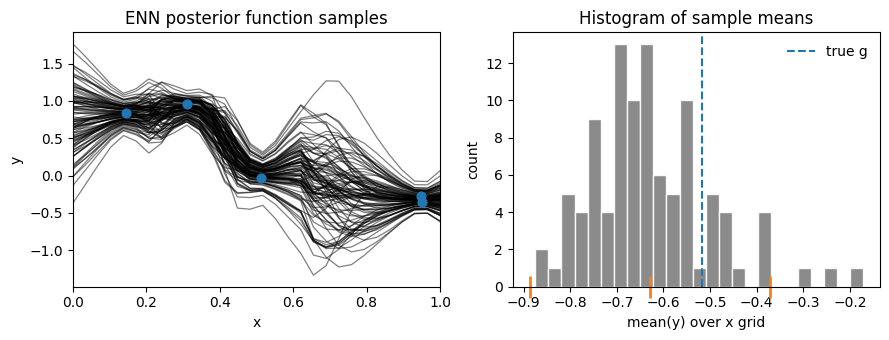

In [4]:
num_dim = 1
num_obs = 5
num_metrics = 1
num_func_draw = 100


rng = np.random.default_rng(1)
function_seeds = list(range(num_func_draw))
train_x = rng.random((num_obs, num_dim))
noise = 0.1
train_y = np.sin(2 * np.pi * train_x) + noise * rng.standard_normal(
    (num_obs, num_metrics)
)
train_yvar = (noise**2) * np.ones((num_obs, num_metrics))

model = EpistemicNearestNeighbors(train_x, train_y, train_yvar)
params = enn_fit(
    model,
    k=min(3, num_obs),
    num_fit_candidates=50,
    num_fit_samples=min(10, num_obs),
    rng=rng,
)

x_hat = np.linspace(0.0, 1.0, 30)
x_hat_2d = x_hat[:, None]


def g(y):
    # Some function of y = draw of f(x)
    return (y**2 - 1).mean()


f_samples_raw = model.posterior_function_draw(
    x_hat_2d, params=params, function_seeds=function_seeds, flags=PosteriorFlags()
)
# `posterior_function_draw` may return either a list of arrays or a single ndarray.
if isinstance(f_samples_raw, list):
    f_samples = np.stack(f_samples_raw, axis=0)
else:
    f_samples = np.asarray(f_samples_raw)

# Shape: (num_func_draw, len(x_hat), num_metrics)
y_vals = f_samples[:, :, 0]
means = (y_vals**2 - 1).mean(axis=1)

fig, (ax_fns, ax_hist) = plt.subplots(1, 2, figsize=(9, 3.5))
ax_fns.plot(x_hat, y_vals.T, color="black", alpha=0.5, linewidth=0.9)

ax_fns.scatter(
    train_x[:, 0],
    train_y[:, 0],
    color="tab:blue",
    s=40,
    zorder=3,
    label="data",
)
ax_fns.set_title("ENN posterior function samples")
ax_fns.set_xlabel("x")
ax_fns.set_ylabel("y")
ax_fns.set_xlim(0, 1)

ax_hist.hist(means, bins=25, color="tab:gray", edgecolor="white", alpha=0.9)

mu = float(np.mean(means))
std = float(np.std(means))
for x_val in [mu, mu - 2 * std, mu + 2 * std]:
    ax_hist.plot(
        [x_val],
        [0.0],
        marker="|",
        markersize=16,
        markeredgewidth=2,
        color="tab:orange",
        transform=ax_hist.get_xaxis_transform(),
        clip_on=False,
    )

true_y = np.sin(2 * np.pi * x_hat)
true_g = g(true_y)
ax_hist.axvline(
    true_g,
    color="tab:blue",
    linestyle="--",
    linewidth=1.5,
    label="true g",
)
ax_hist.legend(frameon=False)

ax_hist.set_title("Histogram of sample means")
ax_hist.set_xlabel("mean(y) over x grid")
ax_hist.set_ylabel("count")

fig.tight_layout()